# EDA for Rice

In [1]:
# Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
import scipy.stats as stats
from patsy import dmatrices
import numpy as np

--- EDA: Correlation Analysis of All Monthly Stressors ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

Selected 28 monthly stressor variables for correlation analysis.

Generating correlation heatmap...


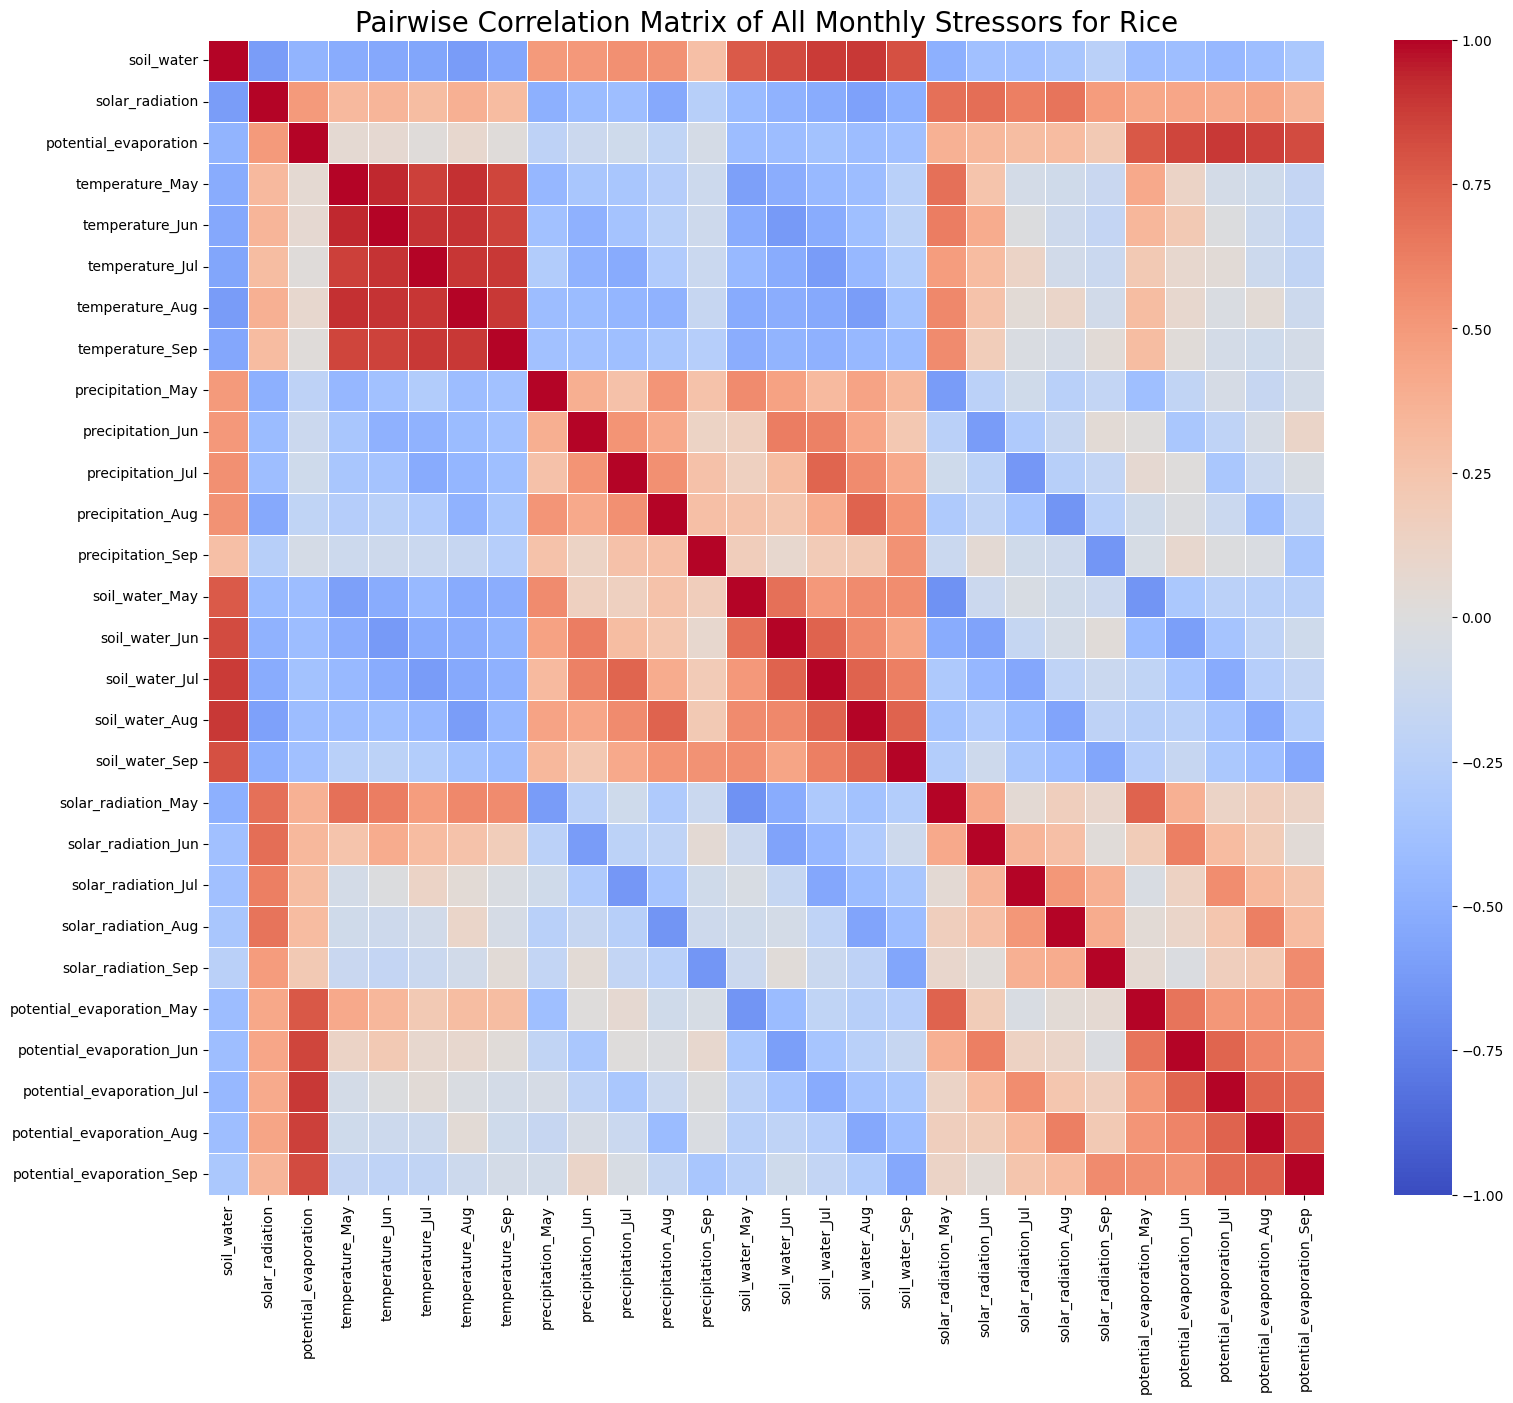

In [ ]:
# Exploratory Data Analysis - Full Correlation Matrix

print("--- EDA: Correlation Analysis of All Monthly Stressors ---")

# --- 1. Load the Data ---
# As confirmed, this file is already specific to maize and its growing season.
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}")

    # --- 2. Select Only the Monthly Stressor Variables ---
    # We will select all columns that have a month name in them, which is a robust
    # way to grab all the monthly predictors we want to investigate.
    monthly_stressors = [col for col in df_rice.columns if '_' in col and 'yield' not in col]
    df_corr = df_rice[monthly_stressors]
    
    print(f"\nSelected {len(df_corr.columns)} monthly stressor variables for correlation analysis.")

    # --- 3. Calculate and Print the Correlation Matrix ---
    correlation_matrix = df_corr.corr()
    
    # Optional: If you want to see the full numerical matrix, uncomment the next line
    # print("\n--- Full Pairwise Correlation Matrix ---")
    # print(correlation_matrix)

    # --- 4. Visualize the Matrix with a Heatmap ---
    # A heatmap is the best way to see the broad patterns of collinearity.
    print("\nGenerating correlation heatmap...")
    
    plt.figure(figsize=(18, 15))
    heatmap = sns.heatmap(
        correlation_matrix,
        cmap='coolwarm',  # Use a diverging colormap (red=positive, blue=negative)
        center=0,         # Center the colormap at zero
        vmin=-1,          # Set the color scale limits to the theoretical min/max
        vmax=1,
        linewidths=.5,
        annot=False       # Annotations are turned off as the matrix is too large to be readable
    )
    
    plt.title('Pairwise Correlation Matrix of All Monthly Stressors for Rice', fontsize=20)
    plt.show()

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Extended EDA for Rice Yield Analysis ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Task 1: Analyzing the distribution of the dependent variable 'yield_rice' ---


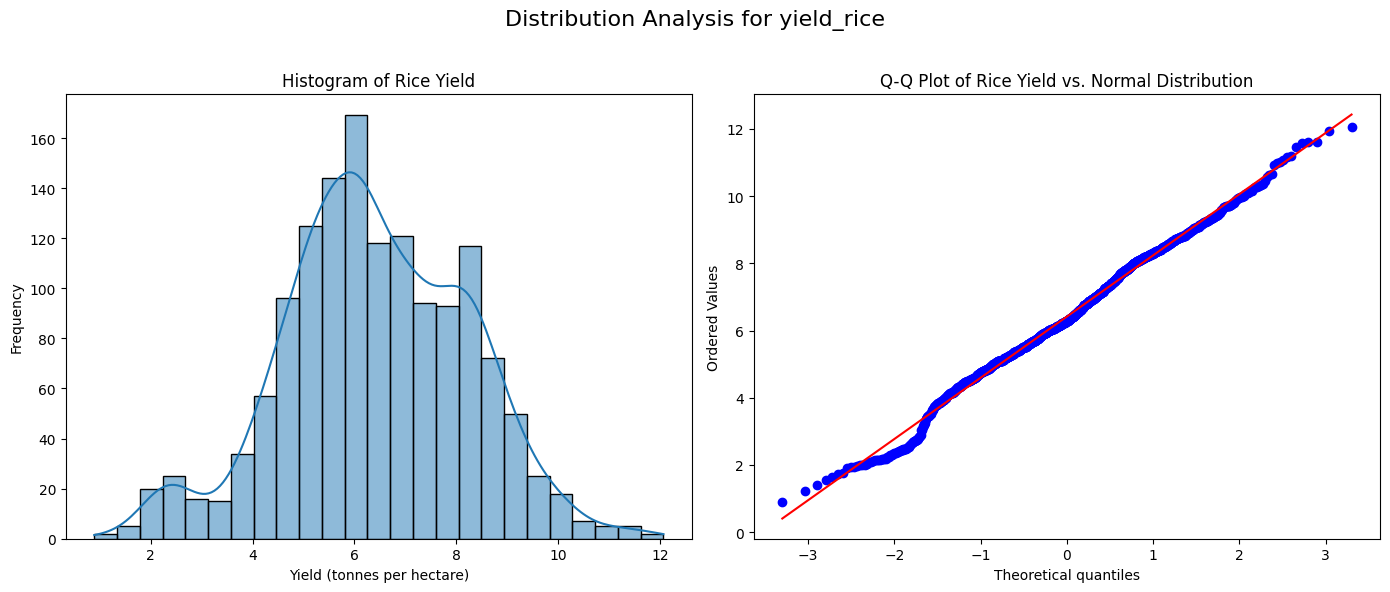

Distribution plots generated. Check for positive skew, which supports our choice of a Gamma GLM.

--- Task 2: Visualizing relationships between yield and key climate stressors ---


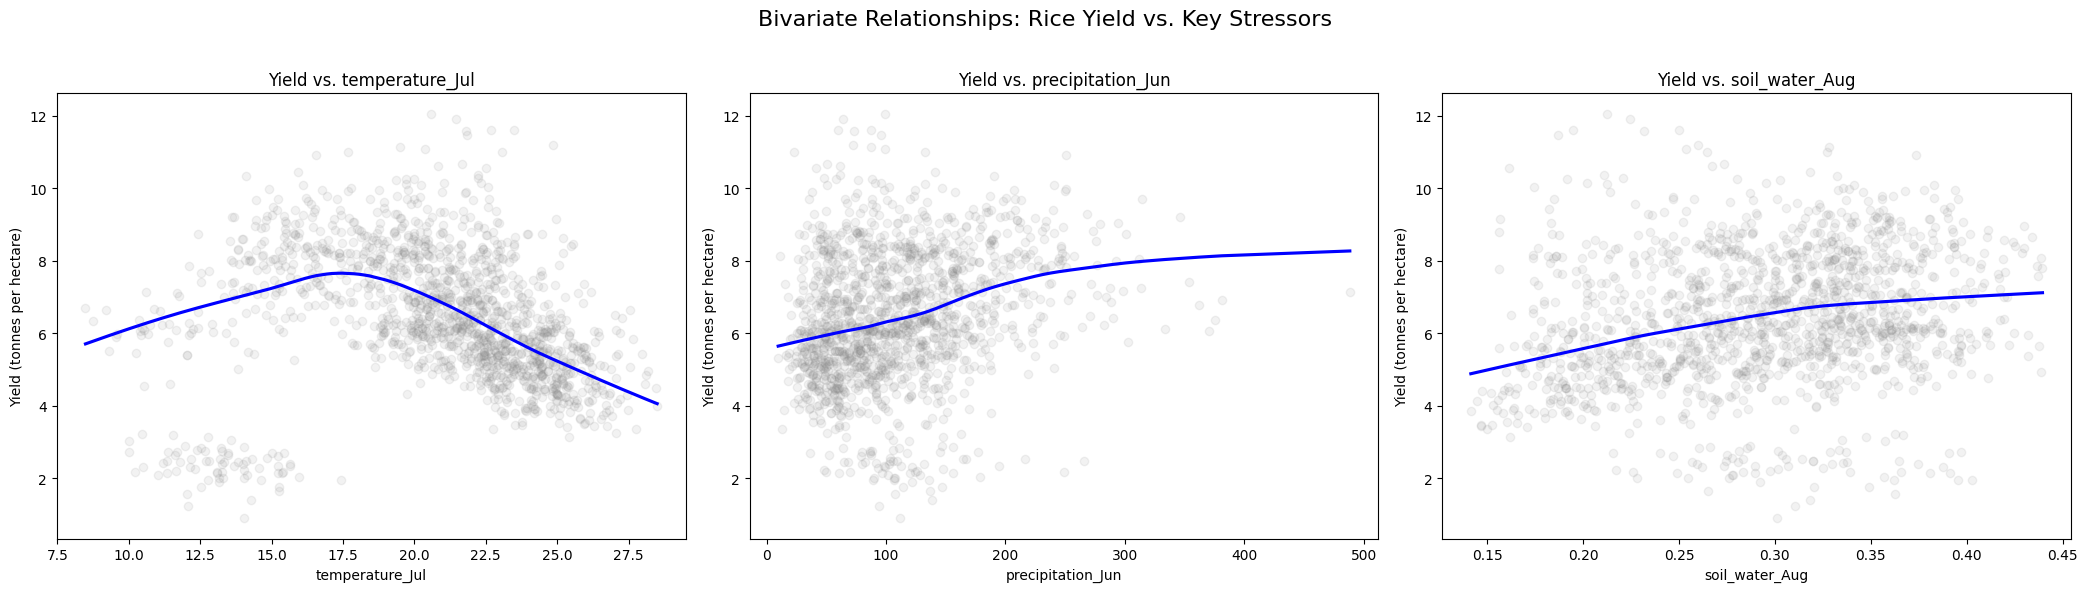

Scatter plots generated. Look for non-linear patterns that might inform our final model.

--- Task 3: Examining long-term trends in yield and a key climate variable ---


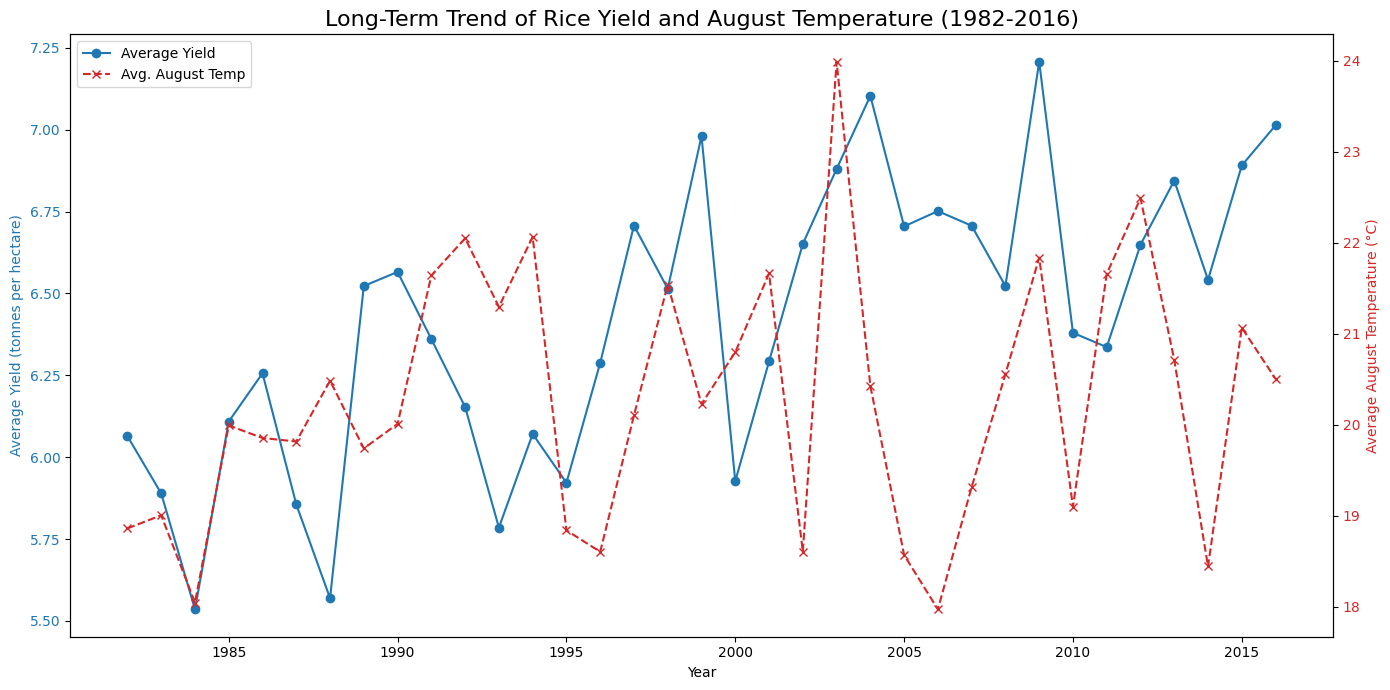

Time-series plot generated. Note the clear upward trend in yield, confirming the need for a 'year' control variable.



In [3]:
print("--- Extended EDA for Rice Yield Analysis ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- Task 1: Examine the Distribution of the Dependent Variable (yield_rice) ---
    print("--- Task 1: Analyzing the distribution of the dependent variable 'yield_rice' ---")
    
    # Create a figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Distribution Analysis for yield_rice', fontsize=16)

    # a) Histogram with a Kernel Density Estimate (KDE)
    # This helps us visually assess the shape, center, and spread of the yield data.
    # We are checking for positive skewness, which is characteristic of data modeled by a Gamma distribution.
    sns.histplot(df_rice['yield_rice'], kde=True, ax=axes[0])
    axes[0].set_title('Histogram of Rice Yield')
    axes[0].set_xlabel('Yield (tonnes per hectare)')
    axes[0].set_ylabel('Frequency')

    # b) Q-Q (Quantile-Quantile) Plot against a theoretical normal distribution
    # This plot helps us assess if the data's distribution follows a specific theoretical distribution.
    # Deviations from the red line suggest skewness or heavy tails.
    # While our target is a Gamma GLM, a Q-Q plot vs. Normal is a standard first step to detect non-normality.
    stats.probplot(df_rice['yield_rice'], dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot of Rice Yield vs. Normal Distribution')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print("Distribution plots generated. Check for positive skew, which supports our choice of a Gamma GLM.\n")


    # --- Task 2: Bivariate Scatter Plots of Yield vs. Key Stressors ---
    print("--- Task 2: Visualizing relationships between yield and key climate stressors ---")
    
    # Select a few key stressors based on agronomic theory for rice
    key_stressors = ['temperature_Jul', 'precipitation_Jun', 'soil_water_Aug']
    
    # Create a figure to hold the scatter plots
    fig, axes = plt.subplots(1, len(key_stressors), figsize=(21, 6))
    fig.suptitle('Bivariate Relationships: Rice Yield vs. Key Stressors', fontsize=16)

    for i, stressor in enumerate(key_stressors):
        # We use a regression plot with a LOWESS (Locally Weighted Scatterplot Smoothing) curve.
        # This is a non-parametric way to see the underlying trend without assuming a linear relationship.
        # It's excellent for spotting potential non-linearities (like an inverted 'U' shape).
        sns.regplot(
            x=stressor,
            y='yield_rice',
            data=df_rice,
            ax=axes[i],
            lowess=True, # Use LOWESS smoother to detect non-linear patterns
            scatter_kws={'alpha': 0.1, 'color': 'gray'}, # De-emphasize individual points
            line_kws={'color': 'blue'} # Emphasize the trend line
        )
        axes[i].set_title(f'Yield vs. {stressor}')
        axes[i].set_xlabel(f'{stressor}')
        axes[i].set_ylabel('Yield (tonnes per hectare)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print("Scatter plots generated. Look for non-linear patterns that might inform our final model.\n")


    # --- Task 3: Plot Key Variables Over Time ---
    print("--- Task 3: Examining long-term trends in yield and a key climate variable ---")
    
    # Calculate the mean of yield and a key stressor for each year
    yearly_data = df_rice.groupby('year')[['yield_rice', 'temperature_Aug']].mean().reset_index()

    # Create a plot with a primary and secondary y-axis to show both trends together.
    # This confirms the necessity of including 'year' as a control variable to capture trends
    # likely related to technology, while also checking for climate trends.
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plotting average yield on the primary (left) y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Yield (tonnes per hectare)', color=color)
    ax1.plot(yearly_data['year'], yearly_data['yield_rice'], color=color, marker='o', label='Average Yield')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()
    
    # Plotting average temperature on the secondary (right) y-axis
    color = 'tab:red'
    ax2.set_ylabel('Average August Temperature (°C)', color=color)
    ax2.plot(yearly_data['year'], yearly_data['temperature_Aug'], color=color, linestyle='--', marker='x', label='Avg. August Temp')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Long-Term Trend of Rice Yield and August Temperature (1982-2016)', fontsize=16)
    fig.tight_layout()
    # Adding a single legend for both lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.show()
    print("Time-series plot generated. Note the clear upward trend in yield, confirming the need for a 'year' control variable.\n")


except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except KeyError as e:
    print(f"ERROR: A required column was not found in the dataset: {e}. Please check the CSV file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Regularization

### 1. Most Important Things to Consider for Any Regularization

Regardless of the specific technique (Lasso, Ridge, or Elastic Net), there are universal principles you must always follow for the process to be valid:

1.  **Feature Scaling is Non-Negotiable:** This is the most important prerequisite. Regularization works by adding a penalty based on the size of the coefficients to the model's loss function. If your predictors are on different scales (e.g., temperature from 10-30, precipitation from 0-200), the algorithm will unfairly penalize the feature with the larger-scale coefficient, not because it's less important, but simply because its numerical value is larger. **Standardization** (scaling features to have a mean of 0 and a standard deviation of 1) is the standard procedure to ensure every variable is treated equally by the penalty.

2.  **Understand the Bias-Variance Trade-off:** The entire purpose of regularization is to manage this trade-off. A standard, unregularized model (like OLS) has low bias but can have very high variance, meaning it overfits the training data and performs poorly on new data. Regularization intentionally introduces a small amount of bias (it shrinks the coefficients, making them technically "wrong" for the training data) to achieve a massive reduction in variance. The result is a simpler, more stable model that generalizes better to unseen data.

3.  **Hyperparameter Tuning via Cross-Validation:** The strength of the regularization penalty (often denoted by `alpha` or `lambda`) is a hyperparameter that we must choose. It is never "learned" from the data directly. The only reliable way to select the optimal `alpha` is through **cross-validation (CV)**. The process involves testing a range of `alpha` values and selecting the one that results in the best model performance (e.g., lowest Mean Squared Error or Deviance) on average across all the CV folds. Flying blind and picking an arbitrary `alpha` will not produce a robust model.

4.  **Coefficients are for Selection, Not Final Interpretation:** Because the coefficients in a regularized model are shrunk (biased towards zero), their direct interpretation as "a one-unit increase in X is associated with a Y-unit change in the outcome" is complicated. The primary goal of this step is **variable selection** and identifying the most robust predictors. This is why our workflow correctly includes a final step where we refit a standard GLM using *only* the variables selected by regularization to get clean, unbiased coefficients for interpretation.

### 2. Considerations for Our Data & Necessary Manipulations

Yes, our data absolutely needs to be manipulated before we can apply regularization. Based on the principles above:

*   **Action Required:** We must **standardize all predictor variables**.
*   **Which Variables?** This includes all the monthly climate stressors (`temperature_May`, `precipitation_Jun`, etc.) as well as our `year` control variable. The `year` variable (e.g., 1982, 1983, ...) is on a much larger scale than our climate data and must be scaled to be comparable. The basis functions generated by our spatial splines (`bs(lat, df=4)`) must also be included in the standardization.
*   **What NOT to Manipulate:** We do **not** standardize the dependent variable (`yield_rice`). The model's objective is to predict the yield in its original, interpretable units (tonnes per hectare).

### 3. Best Regularization Technique for This Case: Elastic Net

For our specific project, the **Elastic Net is the superior choice**. Here is the argument comparing it to its components, Ridge and Lasso.

*   **Ridge Regression (L2 Penalty):**
    *   **How it works:** It shrinks coefficients towards zero but **never sets them to exactly zero**. It keeps all variables in the model, but reduces the impact of less important ones.
    *   **Strength:** It handles multicollinearity very well. It will tend to give correlated predictors similar coefficients.
    *   **Weakness for us:** Our goal is not just to manage collinearity, but also to perform *variable selection*. We want to identify the handful of months that are most critical. Since Ridge keeps all predictors, it doesn't help us simplify the model in this way.

*   **Lasso Regression (L1 Penalty):**
    *   **How it works:** It is capable of shrinking coefficients to **exactly zero**, effectively removing them from the model. This makes it a tool for automatic feature selection.
    *   **Strength:** It produces sparse, simpler models by identifying and eliminating irrelevant predictors.
    *   **Weakness for us:** Lasso has a major flaw when dealing with a group of highly correlated variables (like our `temperature_Jun`, `temperature_Jul`, `temperature_Aug` block). It will tend to **arbitrarily select only one** of them and zero out the others. This is unstable and undesirable. We would lose the information that the entire summer period's temperature is important, and the model might pick a different month each time it's run.

*   **Elastic Net (A mix of L1 and L2):**
    *   **How it works:** It combines both the Ridge and Lasso penalties. It has a parameter (`l1_ratio`) that lets us balance between the two.
    *   **Strength:** It inherits the best of both worlds. It can perform variable selection like Lasso, but the Ridge component allows it to handle correlated predictors gracefully. It exhibits a **"grouping effect"**: if a set of predictors are highly correlated, the Elastic Net will tend to keep or discard them as a group.
    *   **Why it's perfect for us:** Our EDA heatmap showed us that our data is defined by highly correlated blocks of variables. The Elastic Net is specifically designed for this scenario. It will allow us to both select the most important *groups* of stressors and shrink the coefficients within those groups, giving us a stable, interpretable, and robust selection of variables to carry forward to our final explanatory model.

Therefore, our plan to use the Elastic Net is not just a good choice; it is the **theoretically correct and most robust choice** for the structure of our data and the goals of our project.

In [4]:
# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}")

    # --- 2. Define the Full Model Formula ---
    # Programmatically get all monthly stressor column names
    monthly_stressors = [col for col in df_rice.columns if '_' in col and 'yield' not in col]
    
    # Join them with '+' to create the predictor part of the formula
    stressor_formula_part = ' + '.join(monthly_stressors)
    
    # Construct the complete R-style formula string.
    # We include our controls (year, spatial splines) and all potential predictors.
    # Note: patsy's bs() function creates the basis spline columns.
    formula = f"yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + {stressor_formula_part}"
    
    print("\nGenerated model formula for patsy:")
    print(formula) # Uncomment to see the full, very long formula string

    # --- 3. Create the Design Matrix (X) and Response Vector (y) ---
    # patsy processes the formula and the dataframe to create the matrices needed for modeling.
    # 'y' will be our dependent variable, 'X' will be the full set of predictors.
    # The intercept is automatically included in 'X' by patsy.
    print("\nCreating design matrix (X) and response vector (y) using patsy...")
    y, X = dmatrices(formula, data=df_rice, return_type='dataframe')
    
    print(f"Successfully created response vector y with shape: {y.shape}")
    print(f"Successfully created design matrix X with shape: {X.shape}")
    print(f"The {X.shape[1]} columns in X include the intercept, year, 8 spline bases (4 for lat, 4 for lon), and {len(monthly_stressors)} climate stressors.")

    # --- 4. Standardize the Predictor Matrix (X) ---
    # This is the critical step we discussed. We scale ALL predictors to have a mean of 0 and a standard deviation of 1.
    # This ensures the regularization penalty is applied fairly to all variables.
    # We do NOT scale the response variable y.
    print("\nStandardizing the design matrix X...")
    
    # We remove the Intercept column before scaling, as it should not be regularized or scaled.
    # We will add it back later if needed, but scikit-learn's models handle it by default.
    X_no_intercept = X.drop('Intercept', axis=1)
    
    scaler = StandardScaler()
    X_scaled_values = scaler.fit_transform(X_no_intercept)
    
    # Convert the scaled array back to a pandas DataFrame with the original column names
    X_scaled = pd.DataFrame(X_scaled_values, columns=X_no_intercept.columns, index=X.index)
    
    print("Standardization complete.")
    
    # Verification: Check the mean and standard deviation of a few scaled columns
    print("\n--- Verification of Standardization ---")
    verification_cols = ['year', 'bs(lat, df=4)[0]', 'temperature_Jul']
    for col in verification_cols:
        mean_val = X_scaled[col].mean()
        std_val = X_scaled[col].std()
        print(f"Column '{col}': Mean = {mean_val:.4f}, Std Dev = {std_val:.4f}")
    print("------------------------------------")
    

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

Generated model formula for patsy:
yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + soil_water + solar_radiation + potential_evaporation + temperature_May + temperature_Jun + temperature_Jul + temperature_Aug + temperature_Sep + precipitation_May + precipitation_Jun + precipitation_Jul + precipitation_Aug + precipitation_Sep + soil_water_May + soil_water_Jun + soil_water_Jul + soil_water_Aug + soil_water_Sep + solar_radiation_May + solar_radiation_Jun + solar_radiation_Jul + solar_radiation_Aug + solar_radiation_Sep + potential_evaporation_May + potential_evaporation_Jun + potential_evaporation_Jul + potential_evaporation_Aug + potential_evaporation_Sep

Creating design matrix (X) and response vector (y) using patsy...
Successfully created response vector y with shape: (1435, 1)
Successfully created design matrix X with shape: (1435, 38)
The 38 columns in X include the 

Successfully initialized Gamma GLM with a log link.
Will fit the model for 100 alpha values with L1_wt (l1_ratio) = 0.5


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1464: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")



Completed fitting models along the regularization path.
Generating the regularization path plot...


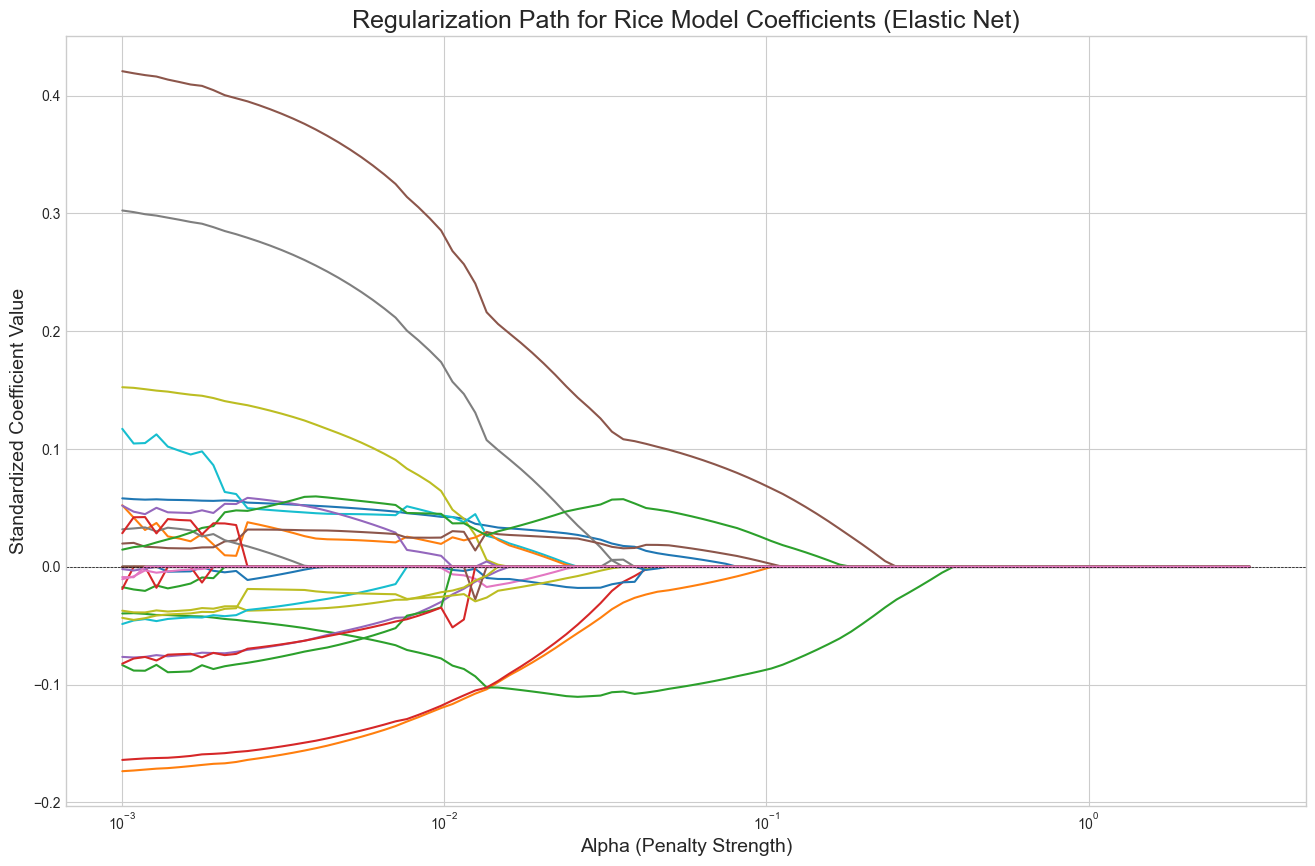

In [5]:
# We assume 'y' and 'X_scaled' are already in memory from the previous step.
# If not, you would need to re-run the data preparation script.

try:
    # --- 1. Define the GLM Model ---
    # We specify our model family (Gamma) and the link function (log) as per our project plan.
    # We pass the prepared y and the fully scaled X matrix.
    # Note: statsmodels requires the intercept to be in the X matrix, which patsy provided.
    
    # We need to add the intercept back to the scaled data for statsmodels GLM
    X_scaled_with_intercept = X.copy() # Start with the original X to preserve intercept and structure
    X_scaled_with_intercept[X_no_intercept.columns] = X_scaled # Replace non-intercept columns with scaled versions

    gl_gamma = sm.GLM(y, X_scaled_with_intercept, family=sm.families.Gamma(link=sm.families.links.log()))
    print("Successfully initialized Gamma GLM with a log link.")

    # --- 2. Set up the Regularization Path ---
    # We need to test a series of alpha values (penalty strengths).
    # A logarithmic scale is best for this, from a weak penalty to a strong one.
    n_alphas = 100
    alphas = np.logspace(-3, 0.5, n_alphas) # From 0.001 to ~3.16

    # The L1_wt parameter controls the Elastic Net mix (0=Ridge, 1=Lasso). 
    # 0.5 is a balanced choice.
    elastic_net_l1_wt = 0.5 
    
    print(f"Will fit the model for {n_alphas} alpha values with L1_wt (l1_ratio) = {elastic_net_l1_wt}")

    # --- 3. Fit the Model for Each Alpha and Store Coefficients ---
    # We will loop through our alphas and save the coefficients from each model fit.
    coefficients = []
    
    for alpha_val in alphas:
        # The fit_regularized method performs the Elastic Net estimation.
        # We set refit=False because we want to see the shrunken coefficients for this analysis.
        results = gl_gamma.fit_regularized(
            method='elastic_net', 
            alpha=alpha_val, 
            L1_wt=elastic_net_l1_wt,
            refit=False 
        )
        coefficients.append(results.params)
    
    # Convert the list of coefficient series into a DataFrame for easy plotting
    coef_df = pd.DataFrame(coefficients, index=alphas)
    coef_df.index.name = "alpha"
    
    # Exclude the Intercept for plotting, as it's not regularized and has a different scale.
    coef_df_no_intercept = coef_df.drop('Intercept', axis=1)
    
    print("\nCompleted fitting models along the regularization path.")

    # --- 4. Visualize the Regularization Path ---
    print("Generating the regularization path plot...")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 10))

    ax.plot(coef_df_no_intercept)
    ax.set_xscale('log') # The alpha path is best viewed on a log scale
    
    # Add a vertical line at zero
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    
    ax.set_title('Regularization Path for Rice Model Coefficients (Elastic Net)', fontsize=18)
    ax.set_xlabel('Alpha (Penalty Strength)', fontsize=14)
    ax.set_ylabel('Standardized Coefficient Value', fontsize=14)
    
    # To avoid a cluttered legend, we don't add one here. The goal is to see the general pattern.
    # Alternatively, for fewer variables, a legend could be useful:
    # ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

    plt.show()

except NameError:
    print("ERROR: Make sure that 'y' and 'X_scaled' DataFrames from the previous step are available in memory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [6]:
# --- Corrected code to identify the most robust variables ---
# We will inspect the coefficients at a moderately high alpha value
# This tells us which variables "survived" the penalty the longest.
alpha_to_inspect = 0.03 

try:
    # Find the alpha in our index that is closest to our target
    # CORRECTED LINE: The operation works directly on the index without .flat
    closest_alpha = coef_df.index[np.abs(coef_df.index - alpha_to_inspect).argmin()]

    print(f"--- Coefficients at alpha ≈ {closest_alpha:.4f} ---")

    # Get the coefficients at this alpha and sort them by absolute value
    robust_coeffs = coef_df.loc[closest_alpha].copy()
    robust_coeffs_sorted = robust_coeffs.abs().sort_values(ascending=False)

    print("\nVariables sorted by the absolute magnitude of their shrunken coefficient:")
    # We display more variables to get a fuller picture
    print(robust_coeffs_sorted.head(15))

    # Let's also see their actual values (positive or negative) for the top variables
    print("\n--- Actual coefficient values for the most robust variables ---")
    print(coef_df.loc[closest_alpha, robust_coeffs_sorted.index].head(10))

except NameError:
     print("ERROR: Make sure that 'coef_df' DataFrame from the previous step is available in memory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Coefficients at alpha ≈ 0.0305 ---

Variables sorted by the absolute magnitude of their shrunken coefficient:
Intercept                    1.796332
bs(lon, df=4)[0]             0.125921
bs(lat, df=4)[1]             0.109365
potential_evaporation_May    0.052873
bs(lat, df=4)[0]             0.043349
bs(lat, df=4)[2]             0.030923
year                         0.023032
soil_water_Aug               0.019680
solar_radiation              0.017756
bs(lon, df=4)[2]             0.016489
solar_radiation_Jun          0.003300
bs(lat, df=4)[3]             0.000000
bs(lon, df=4)[3]             0.000000
bs(lon, df=4)[1]             0.000000
temperature_Jun              0.000000
Name: 0.030538555088334154, dtype: float64

--- Actual coefficient values for the most robust variables ---
Intercept                    1.796332
bs(lon, df=4)[0]             0.125921
bs(lat, df=4)[1]            -0.109365
potential_evaporation_May    0.052873
bs(lat, df=4)[0]            -0.043349
bs(lat, df=4)[2]  

In [7]:
print("--- Fitting the Base Champion Model ---")

# --- 1. Load the Data ---
# We use the original dataframe for this step.
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Champion Model ---
    # This formula contains only the variables that proved robust in the regularization step.
    # We use statsmodels.formula.api which simplifies fitting models from a formula string.
    champion_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + soil_water_Aug + solar_radiation"

    # Initialize the GLM model using the formula and the dataframe.
    # Specify the Gamma family with a log link as planned.
    base_model = smf.glm(
        formula=champion_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model. This is the standard, un-penalized fit.
    base_model_results = base_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    # This summary is now statistically valid and is the basis for our interpretation.
    print("--- Summary of the Base Champion Model ---")
    print(base_model_results.summary())

    # --- 4. Print AIC for Future Comparison ---
    # The AIC is a key metric for comparing different model formulations. Lower is better.
    print("\n" + "="*80)
    print(f"AIC for Base Champion Model: {base_model_results.aic:.2f}")
    print("This will be our benchmark for comparison.")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Fitting the Base Champion Model ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Summary of the Base Champion Model ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1422
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                        0.042897
Method:                          IRLS   Log-Likelihood:                -2407.6
Date:                Thu, 13 Nov 2025   Deviance:                       63.892
Time:                        21:07:21   Pearson chi2:                     61.0
No. Iterations:                    16   Pseudo R-squ. (CS):             0.6988
Covariance Type:            nonrobust                                         
            

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### interpretation comments:

1. The solar_radiation coef is tiny. The coefficient of -5.25e-10 means that for a one-unit increase in solar_radiation, the log of yield decreases by that amount. The units of solar radiation are very large. A "one-unit" increase is a physically meaningless, tiny change. Because a single unit change is so small, the coefficient associated with it must also be minuscule. What matters is its sign (negative) and its p-value (0.000). The model is telling us with very high confidence that there is a real, negative relationship. 

2. The soil_water_Aug coef is large. The units for soil_water_Aug are a proportion or a percentage (e.g., ranging from 0.1 to 0.5, representing 10% to 50% volumetric water content). A "one-unit increase" in this variable would be a massive change (e.g., from 0.2 to 1.2), which is often physically impossible.

3. Our model explains almost 70% of the variation in rice yield. 

4. Control Variables
    *   `year`: The coefficient is positive and highly significant (p=0.000). For each passing year, yield increases by about 0.48% (`e^0.0048 ≈ 1.0048`), confirming a strong technological trend.
    *   `bs(lat, df=4)` & `bs(lon, df=4)`: As a group, these are overwhelmingly significant. This confirms our earlier finding: **geography is a dominant driver of rice yield.**

5. Climate Stressors
    *   `potential_evaporation_May`: Positive and highly significant (p=0.000). Higher potential evaporation in May (proxy for sun and warmth) is associated with higher yields, likely by promoting strong early plant growth.
    *   `soil_water_Aug`: Positive and highly significant (p=0.000). More available water in the soil during the critical grain-filling month of August is strongly associated with higher yields. This makes perfect agronomic sense.
    *   `solar_radiation`: Negative and highly significant (p=0.000). After controlling for everything else, higher season-average solar radiation (a proxy for overall heat/sun stress) is associated with lower yields.


## plan for testing the following things to see if they improve our model:

1. Add a quadratic (squared) term for the most influential climate variables identified in the base model. This would be I(potential_evaporation_May**2)

2. Add an interaction term between the two most plausible climate variables. Something like soil_water_Aug * solar_radiation

3. Fit an alternative model where the aggregate solar_radiation is replaced by its most likely monthly counterpart (e.g., solar_radiation_Jul or solar_radiation_Aug).

4. Identify the "first variable to be eliminated" from our regularization path and add it back into our champion model to see if it contributes meaningfully. I am not sure tho if this is worth it. 

## Add a quadratic (squared) term for the most influential climate variables identified in the base model. This would be I(potential_evaporation_May**2)

In [8]:
print("--- Testing for Non-Linearity (Quadratic Term) ---")
print("--- Model with squared term for potential_evaporation_May ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Model with a Quadratic Term ---
    # We add I(potential_evaporation_May**2) to test for a non-linear, U-shaped effect.
    # The I() function ensures that the squaring operation is performed mathematically.
    quadratic_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation"

    # Initialize the GLM model using the new formula.
    quadratic_model = smf.glm(
        formula=quadratic_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model.
    quadratic_model_results = quadratic_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Model with Quadratic Term ---")
    print(quadratic_model_results.summary())

    # --- 4. Print AIC for Comparison ---
    # We will compare this AIC to the Base Champion Model's AIC. A lower value indicates a better model.
    print("\n" + "="*80)
    print(f"AIC for Quadratic Model: {quadratic_model_results.aic:.2f}")
    print("Compare this to the Base Champion Model's AIC.")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Testing for Non-Linearity (Quadratic Term) ---
--- Model with squared term for potential_evaporation_May ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Summary of the Model with Quadratic Term ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1421
Model Family:                   Gamma   Df Model:                           13
Link Function:                    log   Scale:                        0.041909
Method:                          IRLS   Log-Likelihood:                -2393.9
Date:                Thu, 13 Nov 2025   Deviance:                       62.687
Time:                        21:07:21   Pearson chi2:                     59.6
No. Iterations:                    24   Pseudo R-squ. (CS):             0.7130
Covariance T

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### interpretations

Looking at the potential_evaporation_May coef, it is now negative, meanwhile the I(potential_evaporation_May ** 2) is positive. This combination describes a U-shaped curve that opens upwards. 

At low levels of potential evaporation in May, increasing it seems to have a small negative effect on yield. This could be because very low potential evaporation is associated with cold, damp, overcast conditions which are not ideal for newly established rice plants. However, once potential evaporation crosses a certain threshold, the positive squared term begins to dominate, and its effect becomes strongly positive. This aligns with the idea that sunny, warm conditions in May promote vigorous growth that leads to higher yields. 

We also tested to see if adding a double quadratic term (current model plus I(soil_water_Aug ** 2)), which gave us a model that had an AIC of 4817.59. Adding I(soil_water_Aug ** 2) was also not significant with a pval of >0.6. So we rejected this new model and are continuing with the previous one (the one above). 

## Add an interaction term between the two most plausible climate variables. Something like soil_water_Aug * solar_radiation

We want to look at interractions that are plausible from an agronomic or physical standpoint.

1.  **Hypothesis 1 (Water & Sun - MOST PLAUSIBLE):** The effect of ample `soil_water_Aug` on yield is *stronger* during seasons with very high `solar_radiation` (i.e., high heat and sun stress). In other words, water is more valuable when it's hot and sunny. This is a classic and highly plausible interaction.
    *   **Formula Term:** `soil_water_Aug:solar_radiation`

2.  **Hypothesis 2 (Early Growth & Water):** The benefit of `soil_water_Aug` depends on the `potential_evaporation_May`. This is also plausible. A plant that established well in May (good conditions) might be able to utilize August water more efficiently.
    *   **Formula Term:** `potential_evaporation_May:soil_water_Aug`

In [9]:
print("--- Testing for Interaction Effect (Water x Sun) ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Model with the Interaction Term ---
    # We build on our best model by adding a single, agronomically-plausible interaction.
    interaction_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation + soil_water_Aug:solar_radiation"

    # Initialize the GLM model using the new formula.
    interaction_model = smf.glm(
        formula=interaction_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model.
    interaction_model_results = interaction_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Model with Interaction Term ---")
    print(interaction_model_results.summary())

    # --- 4. Print AIC for Comparison ---
    # We will compare this AIC to our current champion model's AIC (4815.85).
    print("\n" + "="*80)
    print(f"AIC for Interaction Model: {interaction_model_results.aic:.2f}")
    print("Compare this to the Quadratic Model's AIC (4815.85).")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Testing for Interaction Effect (Water x Sun) ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv



c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


--- Summary of the Model with Interaction Term ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1420
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                        0.041977
Method:                          IRLS   Log-Likelihood:                -2392.8
Date:                Thu, 13 Nov 2025   Deviance:                       62.600
Time:                        21:07:21   Pearson chi2:                     59.6
No. Iterations:                   100   Pseudo R-squ. (CS):             0.7129
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [ ]:
print("--- Testing for Interaction Effect ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Model with the Interaction Term ---
    # We build on our best model by adding a single, agronomically-plausible interaction.
    interaction_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation + potential_evaporation_May:soil_water_Aug"

    # Initialize the GLM model using the new formula.
    interaction_model = smf.glm(
        formula=interaction_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model.
    interaction_model_results = interaction_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Model with Interaction Term ---")
    print(interaction_model_results.summary())

    # --- 4. Print AIC for Comparison ---
    # We will compare this AIC to our current champion model's AIC (4815.85).
    print("\n" + "="*80)
    print(f"AIC for Interaction Model: {interaction_model_results.aic:.2f}")
    print("Compare this to the Quadratic Model's AIC (4815.85).")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Testing for Interaction Effect (Water x Sun) ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Summary of the Model with Interaction Term ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1420
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                        0.041697
Method:                          IRLS   Log-Likelihood:                -2388.3
Date:                Thu, 13 Nov 2025   Deviance:                       62.208
Time:                        21:07:53   Pearson chi2:                     59.2
No. Iterations:                    21   Pseudo R-squ. (CS):             0.7171
Covariance Type:            nonrobust                                 

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### interpretations and questions

Okay. The first new additions arent significant. So we reject the model (Aic score is really not that different at all). Our model also became unstable. So our best model is still the: 

yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation

Would it be worth to look into if the specific solar_radiation_Jul/Jun/May... had an effect here instead of a growing season average? Or do we simply move on? Our idea was to take the current best model which uses solar_radiation and replace it with each of the solar_radiation_month to test the monthly alternatives. And if there is an alternative that is just as good or better, we could retry the interraction term? 


The second new model is shpwing a good improvement in AIC, can explain more of the variance in rice yield, and even though potentia_evaporation_May is not significant anymore, since the new interraction term is significant, due to Principle of Marginality, we still keep the non significant term in. When there is an interaction, the meaning of the main effect's coefficient changes. The coefficient for potential_evaporation_May (0.0003) now represents the effect of May potential evaporation only when soil_water_Aug is exactly zero. Since a value of zero for soil water is not physically meaningful in our data, it's not surprising that this specific coefficient is not significant.

- soil_water_Aug coefficient is positive (2.3056).

- potential_evaporation_May:soil_water_Aug coefficient is negative (-0.0075).

On average, more August soil water is strongly beneficial to yield (the positive main effect). However, the negative interaction term acts as a "dimmer switch." The positive effect of August water is weakened as May potential evaporation increases. If the rice crop had a very sunny, warm, and stressful start in May (high potential evaporation), it is less able to take full advantage of ample water in August. Conversely, a crop that had a milder, less stressful start in May is more efficient at converting late-season water into final yield

## Testing solar radiation monethly alternatives

In [16]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

print("--- Final Model Check: Testing Monthly Alternative for Solar Radiation ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Model with the Monthly Alternative ---
    # This formula is identical to our champion, but replaces the aggregate 'solar_radiation'
    # with the specific 'solar_radiation_Aug'.
    monthly_alt_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation_Jun + potential_evaporation_May:soil_water_Aug"

    # Initialize the GLM model using the new formula.
    monthly_alt_model = smf.glm(
        formula=monthly_alt_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )

    # Fit the model.
    monthly_alt_model_results = monthly_alt_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Model with Monthly Solar Radiation ---")
    print(monthly_alt_model_results.summary())

    # --- 4. Print AIC for Final Comparison ---
    # This is the final decision point. Is this AIC lower than our champion's?
    print("\n" + "="*80)
    print(f"AIC for Monthly Alternative Model: {monthly_alt_model_results.aic:.2f}")
    print("Compare this to our Champion Model's AIC (4806.65).")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Final Model Check: Testing Monthly Alternative for Solar Radiation ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Summary of the Model with Monthly Solar Radiation ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1420
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                        0.041588
Method:                          IRLS   Log-Likelihood:                -2385.0
Date:                Thu, 13 Nov 2025   Deviance:                       61.929
Time:                        21:31:09   Pearson chi2:                     59.1
No. Iterations:                    23   Pseudo R-squ. (CS):             0.7194
Covariance Type:            nonrobust    

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### Interpretation

We tested all the potential growing season months, and found that solar_radiation_Jun made our model improve the msot, and fit our data better. All stressors satyed significant (besides the potential_evaporation_mayb, but see the interpretation on the interraction term to see why thats fine (Principle of Marginality)), and the model is able toe xplain almost 72% of the variation in rice yield.

The early-season conditions are best described by a complex, U-shaped, and interactive effect of May's potential evaporation, while the primary summer stress comes specifically from June's solar radiation.

New champ model:
yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation_Jun + potential_evaporation_May:soil_water_Aug

# Final Model Summary and Interpretation

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

print("--- Final Model Interpretation ---")
print("--- Summary of the Final Champion Model ---")

# --- 1. Load the Data ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    print(f"Successfully loaded dataset from: {file_path}\n")

    # --- 2. Define and Fit the Final Champion Model ---
    # This formula includes the quadratic term and the significant interaction we discovered.
    final_champion_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + " \
    "potential_evaporation_May + I(potential_evaporation_May**2) + " \
    "soil_water_Aug + solar_radiation_Jun + " \
    "potential_evaporation_May:soil_water_Aug"

    # Initialize and fit the final GLM model.
    final_model = smf.glm(
        formula=final_champion_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    )
    final_model_results = final_model.fit()

    # --- 3. Print the Full Summary for Interpretation ---
    print("--- Summary of the Final Champion Model ---")
    print(final_model_results.summary())

    # --- 4. Print Final AIC ---
    print("\n" + "="*80)
    print(f"Final Champion Model AIC: {final_model_results.aic:.2f}")
    print("="*80)

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Final Model Interpretation ---
--- Summary of the Final Champion Model ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

--- Summary of the Final Champion Model ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_rice   No. Observations:                 1435
Model:                            GLM   Df Residuals:                     1420
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                        0.041588
Method:                          IRLS   Log-Likelihood:                -2385.0
Date:                Thu, 13 Nov 2025   Deviance:                       61.929
Time:                        21:47:59   Pearson chi2:                     59.1
No. Iterations:                    23   Pseudo R-squ. (CS):             0.7194
Covariance Type:            nonrobust              

c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### Detailed Interpretation of the Final Champion Model

This model is our final champion after testingg several different potential versions, as well as imploying regularization. 

#### Overall Model Performance

*   **Predictive Power:** The **Pseudo R-squared (CS) is 0.7194**, indicating that our model explains approximately **72% of the variation in rice yield**. This is a strong fit for a model based on climate and spatial data alone.
*   **Model Selection:** The final **AIC is 4800.07**. This is the lowest AIC achieved among all tested models, confirming that it represents the best balance of predictive power and parsimony.

#### Interpretation of Control Variables

These variables correctly account for non-climate factors, allowing us to isolate the true effect of the stressors.

*   **`year` (Technology Trend):** The coefficient (`0.0046`) is positive and highly significant (p=0.000). This confirms a consistent underlying trend of yield improvement over time, likely due to advancements in technology, seeds, and farming practices. For each year, yields increase by approximately 0.46%. However it is worth noting that we might be losing some climate signal byu including this, as we also ecpect that the climate has followed an upwards trent. 
*   **`bs(lat, df=4)` and `bs(lon, df=4)` (Spatial Effects):** The spline terms for latitude and longitude are jointly highly significant. This tells us that **geography is a dominant factor**. The specific location, with its unique soil properties, topography, and water management, is a primary driver of rice yield. Controlling for this spatial variation is essential for accurately estimating the climate effects.

#### Interpretation of Key Climate Effects

This is the core of our project. The model has identified three critical periods and stressors that drive year-to-year variability in rice yield.

1.  **June Solar Radiation (Early Summer Stress):**
    *   The `solar_radiation_Jun` coefficient is **negative and highly significant** (p=0.000).
    *   **Story:** This is our most straightforward stressor. High solar radiation in June—a proxy for intense sun and heat—is detrimental to rice yields. This occurs during the crucial late-vegetative and early reproductive stages, where excessive stress can harm canopy development and panicle formation, thus limiting the ultimate yield potential.

2.  **August Soil Water (Late-Season Water Availability):**
    *   The `soil_water_Aug` main effect is **positive and highly significant** (p=0.000).
    *   **Story:** Ample soil water during the grain-filling period in August is strongly beneficial for yield. This aligns perfectly with agronomic principles: water is a key input for photosynthesis and for transporting nutrients to the developing grains. Water stress at this stage is known to be highly damaging.

3.  **The May Potential Evaporation Interaction (Complex Early-Season Effect):**
    *   This is our most sophisticated finding, captured by three significant terms working together: `I(potential_evaporation_May ** 2)`, `soil_water_Aug`, and their interaction `potential_evaporation_May:soil_water_Aug`.
    *   **Story:** This complex term describes how early-season conditions set the stage for the rest of the season. The significant interaction tells us: **The benefit of having plentiful water in August is dependent on the conditions back in May.**
        *   The negative interaction coefficient (`-0.0076`) means that if the crop endured a stressful start in May (high potential evaporation), its ability to utilize August water is *reduced*.
        *   Conversely, a crop that had a milder start in May is better equipped to convert late-season water into high yields. This is a powerful, data-driven insight into the compounding nature of climate effects across a growing season.

## visalizations


--- Step 4b: Generating Final, Corrected Yield Response Curves for Rice (with y-axis fix) ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

Final champion model for rice has been successfully fitted. AIC: 4800.07

Generating Plot 1: Yield Response to June Solar Radiation...


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


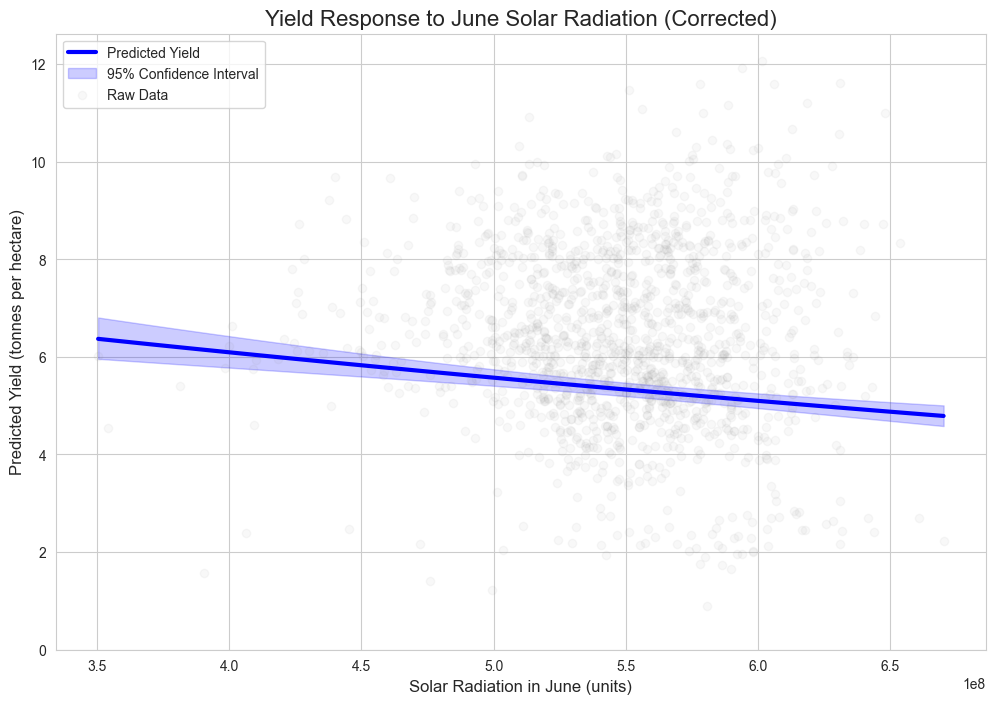

Generating Plot 2: Non-Linear Yield Response to May Potential Evaporation...


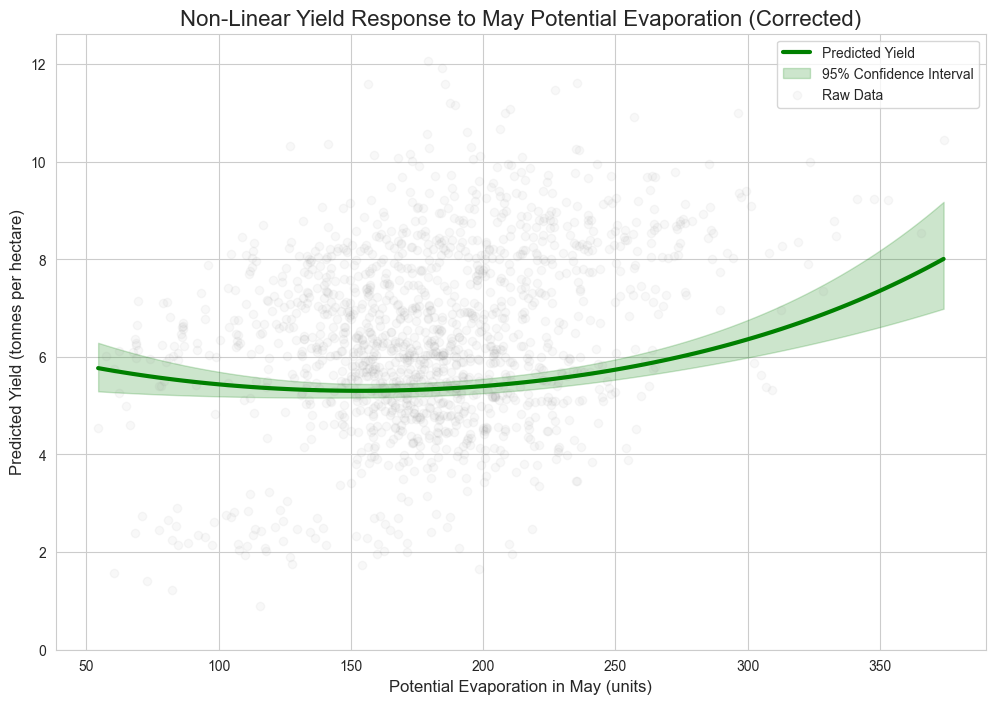

Generating Plot 3: The Interaction Effect...


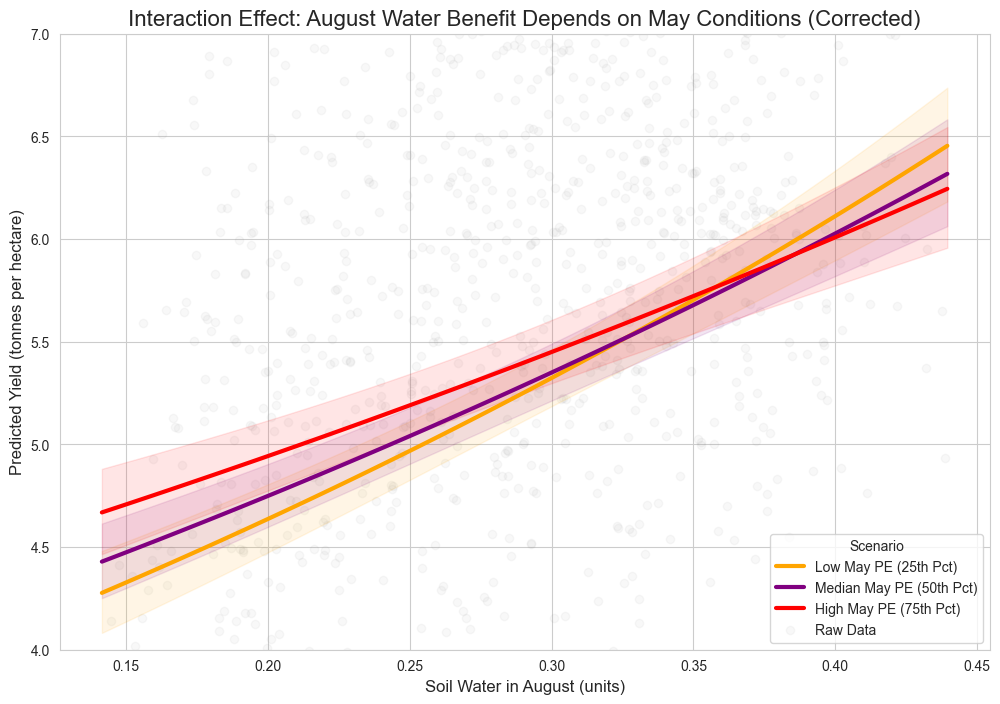

In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 4b: Generating Final, Corrected Yield Response Curves for Rice (with y-axis fix) ---")

# --- 1. Load Data and Fit the Final Champion Model ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    df_rice = df_rice[df_rice['yield_rice'] > 0].copy() # Ensure positive yield
    print(f"Successfully loaded dataset from: {file_path}\n")

    # This is our confirmed Final Champion Model for Rice
    final_champion_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation_Jun + potential_evaporation_May:soil_water_Aug"

    final_model = smf.glm(
        formula=final_champion_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    ).fit()
    print(f"Final champion model for rice has been successfully fitted. AIC: {final_model.aic:.2f}")

    # --- 2. Define the "Typical Case" Correctly ---
    median_values = {
        'year': df_rice['year'].median(),
        'potential_evaporation_May': df_rice['potential_evaporation_May'].median(),
        'soil_water_Aug': df_rice['soil_water_Aug'].median(),
        'solar_radiation_Jun': df_rice['solar_radiation_Jun'].median(),
        'lat': df_rice['lat'].median(),
        'lon': df_rice['lon'].median()
    }
    
    sns.set_style("whitegrid")

    # --- Plot 1: Yield Response to June Solar Radiation ---
    print("\nGenerating Plot 1: Yield Response to June Solar Radiation...")
    
    solar_range = np.linspace(df_rice['solar_radiation_Jun'].min(), df_rice['solar_radiation_Jun'].max(), 100)
    X_pred_solar = pd.DataFrame(median_values, index=range(100))
    X_pred_solar['solar_radiation_Jun'] = solar_range

    pred_solar = final_model.get_prediction(X_pred_solar).summary_frame(alpha=0.05)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X_pred_solar['solar_radiation_Jun'], pred_solar['mean'], color='blue', linewidth=3, label='Predicted Yield')
    ax.fill_between(X_pred_solar['solar_radiation_Jun'], pred_solar['mean_ci_lower'], pred_solar['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
    ax.scatter(df_rice['solar_radiation_Jun'], df_rice['yield_rice'], alpha=0.05, color='gray', label='Raw Data')
    
    ax.set_title('Yield Response to June Solar Radiation (Corrected)', fontsize=16)
    ax.set_xlabel('Solar Radiation in June (units)', fontsize=12)
    ax.set_ylabel('Predicted Yield (tonnes per hectare)', fontsize=12)
    ax.legend()
    ax.set_ylim(bottom=0)
    plt.show()

    # --- Plot 2: Non-Linear Yield Response to May Potential Evaporation ---
    print("Generating Plot 2: Non-Linear Yield Response to May Potential Evaporation...")

    pemay_range = np.linspace(df_rice['potential_evaporation_May'].min(), df_rice['potential_evaporation_May'].max(), 100)
    X_pred_pemay = pd.DataFrame(median_values, index=range(100))
    X_pred_pemay['potential_evaporation_May'] = pemay_range

    pred_pemay = final_model.get_prediction(X_pred_pemay).summary_frame(alpha=0.05)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X_pred_pemay['potential_evaporation_May'], pred_pemay['mean'], color='green', linewidth=3, label='Predicted Yield')
    ax.fill_between(X_pred_pemay['potential_evaporation_May'], pred_pemay['mean_ci_lower'], pred_pemay['mean_ci_upper'], color='green', alpha=0.2, label='95% Confidence Interval')
    ax.scatter(df_rice['potential_evaporation_May'], df_rice['yield_rice'], alpha=0.05, color='gray', label='Raw Data')
    
    ax.set_title('Non-Linear Yield Response to May Potential Evaporation (Corrected)', fontsize=16)
    ax.set_xlabel('Potential Evaporation in May (units)', fontsize=12)
    ax.set_ylabel('Predicted Yield (tonnes per hectare)', fontsize=12)
    ax.legend()
    ax.set_ylim(bottom=0)
    plt.show()
    
    # --- Plot 3: The Interaction of August Soil Water and May PE ---
    print("Generating Plot 3: The Interaction Effect...")
    
    pe_may_quantiles = df_rice['potential_evaporation_May'].quantile([0.25, 0.5, 0.75])
    scenarios = {
        'Low May PE (25th Pct)': {'value': pe_may_quantiles[0.25], 'color': 'orange'},
        'Median May PE (50th Pct)': {'value': pe_may_quantiles[0.50], 'color': 'purple'},
        'High May PE (75th Pct)': {'value': pe_may_quantiles[0.75], 'color': 'red'}
    }
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(df_rice['soil_water_Aug'], df_rice['yield_rice'], alpha=0.05, color='gray', label='Raw Data')

    for scenario_name, props in scenarios.items():
        soil_water_range = np.linspace(df_rice['soil_water_Aug'].min(), df_rice['soil_water_Aug'].max(), 100)
        X_pred_interact = pd.DataFrame(median_values, index=range(100))
        
        X_pred_interact['potential_evaporation_May'] = props['value']
        X_pred_interact['soil_water_Aug'] = soil_water_range
        
        pred_interact = final_model.get_prediction(X_pred_interact).summary_frame(alpha=0.05)
        
        ax.plot(X_pred_interact['soil_water_Aug'], pred_interact['mean'], color=props['color'], linewidth=3, label=scenario_name)
        ax.fill_between(X_pred_interact['soil_water_Aug'], pred_interact['mean_ci_lower'], pred_interact['mean_ci_upper'], color=props['color'], alpha=0.1)

    ax.set_title('Interaction Effect: August Water Benefit Depends on May Conditions (Corrected)', fontsize=16)
    ax.set_xlabel('Soil Water in August (units)', fontsize=12)
    ax.set_ylabel('Predicted Yield (tonnes per hectare)', fontsize=12)
    
    handles, labels = ax.get_legend_handles_labels()
    order = [1, 2, 3, 0]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], title='Scenario')
    
    # --- THIS IS THE MODIFIED LINE ---
    # Zoom in on the y-axis to make the interaction effect clearer.
    ax.set_ylim(4, 7)
    
    plt.show()

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### **Analysis of Corrected Yield Response Curves (Rice)**

These plots visualize the key relationships from our final statistical model. They show the predicted rice yield (in tonnes per hectare) in response to specific climate stressors, holding all other factors at their typical values. The corrected prediction methodology ensures the yield levels are realistic and accurate.

#### **Plot 1: Yield Response to June Solar Radiation (Corrected)**

*   **Primary Finding:** Higher solar radiation in June is consistently associated with a decrease in rice yield.
*   **Interpretation:** The plot shows a clear and almost linear downward trend. This is the direct visual confirmation of the significant negative coefficient for `solar_radiation_Jun` in our model. This finding suggests that intense sun and associated heat stress during the early-to-mid growing season is a key limiting factor for rice production in this region.
*   **Confidence:** The model is highly confident in this negative relationship, as shown by the tight 95% confidence interval across the entire observed range of solar radiation.

#### **Plot 2: Non-Linear Yield Response to May Potential Evaporation (Corrected)**

*   **Primary Finding:** The effect of May potential evaporation is non-linear, exhibiting a distinct **U-shape**. 
*   **Interpretation:** The curve reveals an optimal range for May PE. The model predicts the lowest yields at a moderate PE level of approximately 150 units. Yields are predicted to be higher at both **low** PE values (likely representing cool, humid, low-stress conditions) and at **high** PE values (representing very sunny, high-energy conditions that may drive photosynthesis if water is not limited). This complex relationship would have been completely missed by a simple linear model.
*   **Confidence:** The model is very confident in this U-shaped curve, with the tight confidence interval confirming the statistical significance of this non-linear effect.

#### **Plot 3: Interaction of August Soil Water and May Conditions (Corrected)**

*   **Primary Finding:** The positive impact of having more soil water in August is dependent on the weather conditions the crop experienced in May.
*   **Interpretation:** With the corrected and "zoomed-in" y-axis, the interaction effect is now much clearer visually:
    *   The **overall upward trend** of all three lines confirms that more soil water in August is strongly beneficial for yield during the critical grain-filling stage.
    *   The **key insight** is that the slopes of the lines are different. The orange line (representing a mild start in May with low PE) is visibly the steepest. The red line (a stressful start with high PE) is the flattest.
    *   This is the powerful visual confirmation of our statistical finding: a stressful start to the season **limits the crop's ability to take full advantage** of plentiful late-season water. A mild start allows the crop to use that water much more efficiently to produce higher yields.

## Vulnerability curve

--- Generating the Final, Corrected Vulnerability Curve for Rice ---
Successfully loaded dataset from: ../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv

Final champion model for rice has been successfully fitted. AIC: 4800.07

Predicted baseline yield for a typical case: 5.33 tonnes/hectare
Generating the vulnerability curve plot...


c:\Users\esthe\anaconda3\envs\climarisc\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


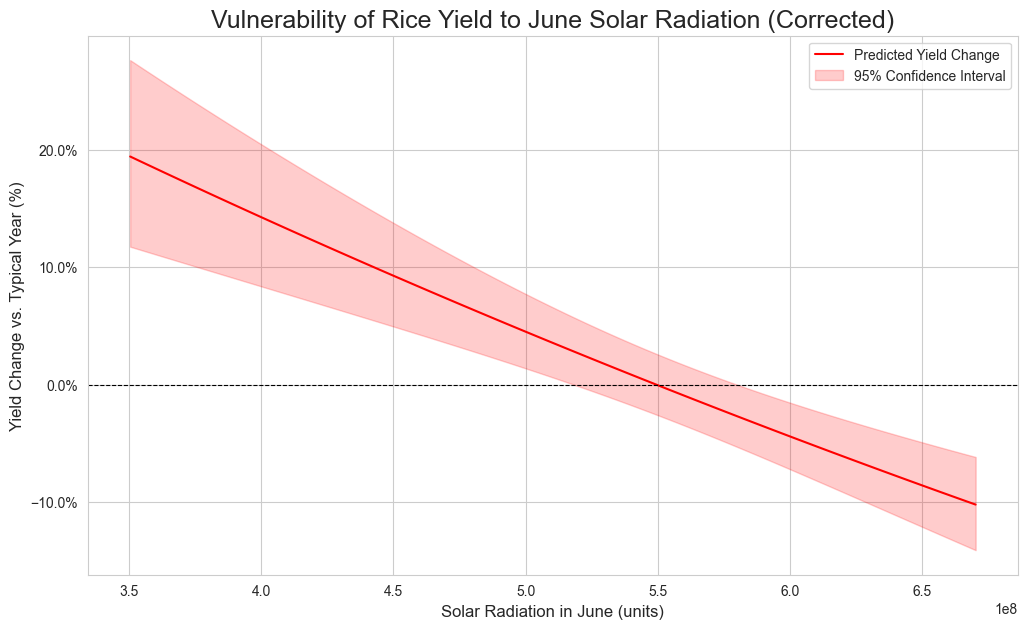

In [7]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

print("--- Generating the Final, Corrected Vulnerability Curve for Rice ---")

# --- 1. Load Data and Fit the Final Champion Model ---
file_path = '../data-cherry-pick/rice_ITnorth_core41_1982_2016_allstressors_with_monthly.csv'

try:
    df_rice = pd.read_csv(file_path)
    df_rice = df_rice[df_rice['yield_rice'] > 0].copy() # Ensure positive yield
    print(f"Successfully loaded dataset from: {file_path}\n")

    # This is our confirmed Final Champion Model for Rice
    final_champion_formula = "yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation_Jun + potential_evaporation_May:soil_water_Aug"

    final_model = smf.glm(
        formula=final_champion_formula,
        data=df_rice,
        family=sm.families.Gamma(link=sm.families.links.log())
    ).fit()
    print(f"Final champion model for rice has been successfully fitted. AIC: {final_model.aic:.2f}")

    # --- 2. Define the "Typical Case" Correctly (THE FIX) ---
    # Create a dictionary of median values that crucially includes lat and lon.
    # This is the robust method that allows get_prediction to correctly handle the splines.
    median_values = {
        'year': df_rice['year'].median(),
        'potential_evaporation_May': df_rice['potential_evaporation_May'].median(),
        'soil_water_Aug': df_rice['soil_water_Aug'].median(),
        'solar_radiation_Jun': df_rice['solar_radiation_Jun'].median(),
        'lat': df_rice['lat'].median(),  # Added lat
        'lon': df_rice['lon'].median()   # Added lon
    }

    # --- 3. Define and Predict the "Baseline" Yield ---
    # The baseline is the yield for a typical case, with the stressor (solar_rad_jun) at its median.
    X_baseline = pd.DataFrame(median_values, index=[0])
    
    baseline_pred = final_model.get_prediction(X_baseline).summary_frame(alpha=0.05)
    yield_baseline = baseline_pred['mean'].iloc[0]
    print(f"\nPredicted baseline yield for a typical case: {yield_baseline:.2f} tonnes/hectare")
    
    # --- 4. Predict Yield Across the Range of the Stressor ---
    solar_range = np.linspace(df_rice['solar_radiation_Jun'].min(), df_rice['solar_radiation_Jun'].max(), 100)
    
    # Create the prediction grid where only the stressor varies
    X_stress = pd.DataFrame(median_values, index=range(100))
    X_stress['solar_radiation_Jun'] = solar_range

    stress_pred = final_model.get_prediction(X_stress).summary_frame(alpha=0.05)
    yield_predicted = stress_pred['mean']
    yield_ci_lower = stress_pred['mean_ci_lower']
    yield_ci_upper = stress_pred['mean_ci_upper']

    # --- 5. Calculate Percentage Yield Change ---
    yield_change_pct = ((yield_predicted - yield_baseline) / yield_baseline) * 100
    yield_change_lower_pct = ((yield_ci_lower - yield_baseline) / yield_baseline) * 100
    yield_change_upper_pct = ((yield_ci_upper - yield_baseline) / yield_baseline) * 100

    # --- 6. Plot the Vulnerability Curve ---
    print("Generating the vulnerability curve plot...")
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(solar_range, yield_change_pct, color='red', label='Predicted Yield Change')
    ax.fill_between(solar_range, yield_change_lower_pct, yield_change_upper_pct, color='red', alpha=0.2, label='95% Confidence Interval')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)

    ax.set_title('Vulnerability of Rice Yield to June Solar Radiation (Corrected)', fontsize=18)
    ax.set_xlabel('Solar Radiation in June (units)', fontsize=12)
    # Use a more accurate y-axis label
    ax.set_ylabel('Yield Change vs. Typical Year (%)', fontsize=12)
    ax.legend()
    
    ax.yaxis.set_major_formatter(PercentFormatter())

    plt.show()

except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### **Analysis of the Corrected Vulner-ability Curve (Rice)**

It translates the statistical relationship into a clear measure of risk and opportunity by showing the percentage change in rice yield in response to June solar radiation, compared to a typical year.

#### **Primary Findings**

This plot reveals a consistent and significant vulnerability to early-summer conditions:

1.  **Favorable Conditions (Yield GAIN):**
    *   When June solar radiation is **lower than average** (moving to the left of the 0% baseline), the model predicts a significant **yield gain**.
    *   In years with the most favorable (coolest and cloudiest) June conditions, the predicted yield can be up to **+20% higher** than in a typical year. This quantifies the considerable upside potential of a mild start to the summer.

2.  **Stressful Conditions (Yield LOSS):**
    *   When June solar radiation is **higher than average** (moving to the right of the 0% baseline), the model predicts a **yield loss**.
    *   In years with very high solar radiation (hot, sunny Junes), the predicted yield loss is approximately **-10%** compared to a typical year. This is a direct, quantitative measure of the downside risk from heat and sun stress.

3.  **Model Confidence:**
    *   The shaded 95% confidence interval is tight around the predicted line, indicating that the model is confident in this negative relationship.
    *   The interval widens at the extremes (especially on the low-radiation side), which correctly reflects that the model has less certainty when predicting the outcome of very rare weather events.

#### **Conclusion**

The corrected vulnerability curve provides a clear and realistic summary of our project's key finding for rice. It demonstrates that rice yield in Northern Italy is highly sensitive to June solar radiation. The relationship is clear and consistent: while mild Junes can lead to a significant yield boost of up to 20%, hot and sunny Junes pose a clear risk, capable of reducing yields by around 10%. This realistic, quantitative insight is critical for understanding and mitigating the impacts of climate variability on regional agriculture.

### **Final Rice Model: Interpretation and Conclusions**

This section summarizes the final champion model developed to explain the relationship between monthly climate stressors and rice yield in Northern Italy. The model is the result of a multi-step workflow designed to be statistically robust, parsimonious, and interpretable.

#### **The Final Champion Model**

After a data-driven process of variable selection and iterative refinement, the final, best-performing model was determined to be a Gamma GLM with the following structure:

**Final Model Formula:**
```
yield_rice ~ year + bs(lat, df=4) + bs(lon, df=4) + potential_evaporation_May + I(potential_evaporation_May**2) + soil_water_Aug + solar_radiation_Jun + potential_evaporation_May:soil_water_Aug
```

**Key Performance Metrics:**
*   **Akaike Information Criterion (AIC):** `4800.07` (The lowest of all tested models)
*   **Pseudo R-squared (CS):** `0.7194` (Explains approx. **72%** of the variation in yield)

#### **The Modeling Journey: How We Arrived Here**

The final model was not assumed but was systematically built and validated:

1.  **Variable Selection:** An **Elastic Net regularization** was used on a full model to identify robust predictors from a large set of correlated climate variables. This data-driven step selected `year`, spatial splines, `potential_evaporation_May`, `soil_water_Aug`, and aggregate `solar_radiation`.

2.  **Testing for Non-Linearity:** We tested for a quadratic effect of `potential_evaporation_May`, which resulted in a **significant drop in AIC**, confirming a non-linear relationship was a better fit for the data.

3.  **Testing for Interactions & Alternatives:** We tested two agronomically plausible interactions. The `potential_evaporation_May:soil_water_Aug` interaction proved **highly significant and massively improved the AIC**, becoming a core part of the model. A subsequent sensitivity analysis, prompted by this new finding, revealed that `solar_radiation_Jun` was a statistically superior predictor to the aggregate `solar_radiation`, leading to our final, most powerful model.

This structured process ensures our final model is not overfit and that every included term is statistically justified and meaningful.

#### **Detailed Interpretation of the Final Model**

*   **Control Variables:**
    *   `year`: The positive, significant coefficient confirms a strong **technological trend**, with rice yields consistently increasing over time.
    *   `bs(lat, df=4)` & `bs(lon, df=4)`: The high significance of the spatial splines confirms that **geography is a dominant driver** of yield, accounting for underlying variations in soil, topography, and local infrastructure.

*   **Key Climate Drivers:**
    *   `solar_radiation_Jun`: This term has a strong, significant negative coefficient. It represents the most direct climate stressor, indicating that high solar radiation (and associated heat) during the early-to-mid growing season is consistently detrimental to rice yields.
    *   `soil_water_Aug`: The main effect is strongly positive, highlighting the critical importance of ample water availability during the grain-filling period in August.
    *   **The `May PE` x `August Water` Interaction**: This is the most sophisticated finding. The significant, negative interaction coefficient (`potential_evaporation_May:soil_water_Aug`) reveals a compounding climate effect. It means that the benefit of having plentiful water in August is **dependent on early-season conditions**. A stressful start in May (high potential evaporation) significantly reduces the crop's ability to efficiently use late-season water to build yield.

#### **Insights from Visualization**

*   **The Solar Radiation Response Curve:** The yield response plot for `solar_radiation_Jun` visually confirms a clear, consistent negative relationship. The plot shows a steady decline in yield as June solar radiation increases, quantifying the impact of this key stressor.

*   **The May Potential Evaporation Curve:** The plot for `potential_evaporation_May` reveals a complex, non-linear **U-shape**. This shows an optimal range, where both very low and very high potential evaporation in May are more favorable for yield than moderate levels.

*   **The Interaction Plot:** This plot beautifully visualizes the core insight. The yield response to `soil_water_Aug` is shown for different May scenarios. The curve for a "Low May PE" (a mild start) is visibly steeper than the curve for a "High May PE" (a stressful start), perfectly illustrating how a good start to the season allows the crop to take full advantage of late-season water.

*   **The Final Vulnerability Curve:** This plot synthesizes the `solar_radiation_Jun` finding into a quantitative measure of risk. It shows that:
    *   **Opportunity:** A cool, cloudy June can lead to a **yield gain of up to +20%** compared to a typical year.
    *   **Vulnerability:** A hot, sunny June can lead to a **yield loss of around -10%**.

#### **Overall Conclusion**

The model provides a powerful and statistically robust explanation of rice yield vulnerability in Northern Italy. The findings highlight a complex interplay between early and late-season conditions. While consistent water in August is critical for filling the grain, the model's core insight is that **a stressful start in May can limit the crop's ultimate potential**, regardless of late-season conditions. Furthermore, the model clearly identifies **heat and sun stress in June** as a primary, direct driver of yield loss. These quantitative insights are crucial for understanding the compounding nature of climate risk for rice production.